<font size=7 color ="#5499C7" >Audio MNIST</font>
- <font size=5>__Done By__ : Kasra Noorbakhsh</font>
- <font size=5>__UID__  : 810100230</font>
- <font size=5>__Goal__  : Digit Recognition</font>

### <p align="justify"><font size="6" color="#d62b5b">Step 1: Initialization and Overview</font></p>
<p align="justify">

<p align="justify"><font size="6" color="#A9CCE3"><b>Section 0: Setup & imports</b></font><br></p>

In [1]:
# Standard library
import os
import random
import logging
import csv

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import librosa
import soundfile as sf
from glob import glob
from tqdm import tqdm
from pathlib import Path

def set_seed(seed=42):
    """Set seeds across libraries for reproducible results."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

print("Library versions for reproducibility:")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Torch: {torch.__version__}")
print(f"Librosa: {librosa.__version__}")
print(f"SoundFile: {sf.__version__}")

# Paths (using Path for better handling)
DATA_DIR = Path("/kaggle/input/audio-mnist/data")
CACHE_DIR = Path("/kaggle/working/cache")
WORK_DIR = Path("/kaggle/working")

CACHE_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters (general + SNN-specific)
TARGET_SR = 16000  # Target sample rate (original is 48kHz, downsample for efficiency)
TARGET_LEN = TARGET_SR  # 1 second of audio (pad/truncate to this)
N_MELS = 128  # Number of Mel filters
HOP_LENGTH = 512  # Hop length for STFT
N_FFT = 1024  # FFT window size
NUM_CLASSES = 10  # Digits 0-9
BATCH_SIZE = 64  # May reduce to 32 if SNN time steps cause OOM
NUM_EPOCHS = 20  # Increased for SNN (slower convergence)
RANDOM_SEED = 42  # Consistent with set_seed

# SNN-specific params (tune for performance; time steps simulate spiking dynamics)
TIME_STEPS = 20  # Number of simulation time steps (higher = better acc, but slower)
DECAY_MULTIPLIER = 0.9  # Neuron membrane decay rate (0-1; lower = faster decay)
THRESHOLD = 1.0  # Firing threshold for LIF neurons
PENALTY_THRESHOLD = 1.5  # Refractory penalty to reset after spike

Library versions for reproducibility:
NumPy: 1.26.4
Pandas: 2.2.3
Torch: 2.6.0+cu124
Librosa: 0.11.0
SoundFile: 0.13.1
Using device: cuda


#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 1: Gather file list & quick metadata</b></font></p>

In [2]:
# # Data metadata extraction
# from kaggle.api.kaggle_api_extended import KaggleApi  # For optional dataset download (install if needed)

# # Optional: Download dataset if not in Kaggle (for local reproducibility)
# if not DATA_DIR.exists():
#     print("Dataset not found locally. Downloading from Kaggle...")
#     try:
#         api = KaggleApi()
#         api.authenticate()  # Requires ~/.kaggle/kaggle.json with API token
#         api.dataset_download_files('sripaadsrinivasan/audio-mnist', path=str(WORK_DIR), unzip=True)
#         # Assume downloaded to /kaggle/working/data; adjust DATA_DIR
#         DATA_DIR = WORK_DIR / "data"
#         print(f"Dataset downloaded to {DATA_DIR}")
#     except Exception as e:
#         print(f"Error downloading dataset: {e}. Please download manually from https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist")

rows = []
bad_files = []

# Iterate over speaker folders
speaker_folders = sorted(list(DATA_DIR.glob("*")))  # Sorted for reproducibility
for speaker_folder in tqdm(speaker_folders, desc="Processing speakers"):
    speaker_id = speaker_folder.name
    if not speaker_id.isdigit():
        continue  # Skip non-speaker folders
    # Iterate over WAV files with progress (if many)
    wav_paths = list(speaker_folder.glob("*.wav"))
    for wav_path in tqdm(wav_paths, desc=f"Processing speaker {speaker_id}", leave=False):
        fname = wav_path.name
        parts = fname.replace(".wav", "").split("_")
        if len(parts) < 3:
            bad_files.append(str(wav_path))
            rows.append({"path": str(wav_path), "speaker": speaker_id, "digit": None, "iter": None, "flag_bad_name": True})
            continue
        try:
            digit = int(parts[0])
            speaker_code = parts[1]
            iteration = parts[2]
            # Check if speaker_code matches speaker_id
            if speaker_code != speaker_id:
                bad_files.append(str(wav_path))
                rows.append({"path": str(wav_path), "speaker": speaker_id, "digit": digit, "iter": iteration, "flag_bad_name": True, "note": "Speaker mismatch"})
                continue
            if digit < 0 or digit > 9:
                raise ValueError("Invalid digit")
        except (ValueError, IndexError):
            bad_files.append(str(wav_path))
            rows.append({"path": str(wav_path), "speaker": speaker_id, "digit": None, "iter": None, "flag_bad_name": True})
            continue
        rows.append({"path": str(wav_path), "speaker": speaker_id, "digit": digit, "iter": iteration, "flag_bad_name": False})

df = pd.DataFrame(rows)
df['digit'] = df['digit'].astype('Int64')  # Handle None as <NA>

# Sort DF for reproducibility
df = df.sort_values(by='path').reset_index(drop=True)

# Logging (to file for repro)
logging.info(f"Total files: {len(df)} (Expected ~30,000 for full dataset)")
if bad_files:
    logging.warning(f"Bad files found: {len(bad_files)}. Examples: {bad_files[:5]}")
    print(f"Bad files found: {len(bad_files)}. Examples: {bad_files[:5]}")
else:
    print("No bad files found.")
print(df.head())

# Save DF to cache for faster reloads
df.to_csv(CACHE_DIR / "metadata.csv", index=False)
print("Metadata saved to cache for reproducibility.")

Processing speaker 01:   0%|          | 0/500 [00:00<?, ?it/s]
                                                              
Processing speaker 02:   0%|          | 0/500 [00:00<?, ?it/s]
                                                              
Processing speaker 04:   0%|          | 0/500 [00:00<?, ?it/s]
                                                              
Processing speaker 05:   0%|          | 0/500 [00:00<?, ?it/s]
                                                              
Processing speaker 06:   0%|          | 0/500 [00:00<?, ?it/s]
                                                              
Processing speaker 08:   0%|          | 0/500 [00:00<?, ?it/s]
                                                              
Processing speaker 09:   0%|          | 0/500 [00:00<?, ?it/s]
                                                              
Processing speaker 10:   0%|          | 0/500 [00:00<?, ?it/s]
                                                       

No bad files found.
                                            path speaker  digit iter  \
0   /kaggle/input/audio-mnist/data/01/0_01_0.wav      01      0    0   
1   /kaggle/input/audio-mnist/data/01/0_01_1.wav      01      0    1   
2  /kaggle/input/audio-mnist/data/01/0_01_10.wav      01      0   10   
3  /kaggle/input/audio-mnist/data/01/0_01_11.wav      01      0   11   
4  /kaggle/input/audio-mnist/data/01/0_01_12.wav      01      0   12   

   flag_bad_name  
0          False  
1          False  
2          False  
3          False  
4          False  
Metadata saved to cache for reproducibility.


#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 2: Durations and sample rate checks</b></font></p>

Running full inspection (all files)...


Inspecting files: 100%|██████████| 30000/30000 [04:58<00:00, 100.51it/s]


Sample rate(s) found: {48000}
Duration stats: mean=0.643s, median=0.632s, max=1.000s


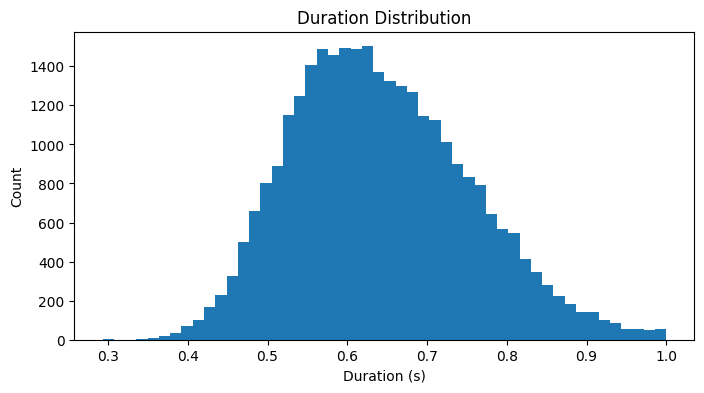

In [3]:
# Audio file inspection: Sample rates and durations
# Set up logging for reproducibility
logging.basicConfig(filename=str(CACHE_DIR / "audio_inspection.log"), level=logging.INFO)

def inspect_audio_files(df, sample_size=1000, full_check=False, random_seed=RANDOM_SEED):
    """Inspect sample rates and durations of audio files."""
    if full_check:
        paths = df['path'].tolist()
        print("Running full inspection (all files)...")
    else:
        paths = df['path'].sample(min(sample_size, len(df)), random_state=random_seed).tolist()
        print(f"Running sample inspection ({len(paths)} files)...")
    
    if not paths:
        print("No paths to inspect.")
        return
    
    durations = []
    sr_set = set()
    for p in tqdm(paths, desc="Inspecting files"):
        try:
            p = Path(p)  # Ensure Path
            info = sf.info(p)
            sr_set.add(info.samplerate)
            durations.append(info.duration)  # Use info.duration directly (frames / sr)
            # Optional: Check channels (should be 1 for mono)
            if info.channels != 1:
                logging.warning(f"Non-mono file: {p} (channels={info.channels})")
        except Exception as e:
            print(f"Failed reading {p}: {e}")
            logging.error(f"Failed reading {p}: {e}")
    
    if not durations:
        print("No valid files inspected.")
        return
    
    # Stats
    mean_dur = np.mean(durations)
    median_dur = np.median(durations)
    max_dur = np.max(durations)
    print(f"Sample rate(s) found: {sr_set}")
    if len(sr_set) > 1:
        print("Warning: Multiple sample rates detected! May need normalization.")
    print(f"Duration stats: mean={mean_dur:.3f}s, median={median_dur:.3f}s, max={max_dur:.3f}s")
    logging.info(f"SR: {sr_set}, Durations: mean={mean_dur:.3f}, median={median_dur:.3f}, max={max_dur:.3f}")
    
    # Plot histogram
    plt.figure(figsize=(8, 4))
    plt.hist(durations, bins=50)
    plt.xlabel("Duration (s)")
    plt.ylabel("Count")
    plt.title("Duration Distribution")
    plt.savefig(WORK_DIR / "duration_histogram.png")
    plt.show()
    plt.close()  # Free memory

# Run inspection (set full_check=True for all files, but it's slow)
inspect_audio_files(df, sample_size=1000, full_check=True)

### <p align="justify"><font size="6" color="#d62b5b">Step 2: Data cleaning and preprocessing</font></p>
<p align="justify">

- 

- 

- 

- 

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 3: Preprocessing Functions</b></font></p>

In [4]:
def load_and_preprocess(path, target_sr=TARGET_SR, target_len=TARGET_LEN):
    """
    Load audio file, resample, normalize, trim silence, and pad/truncate to fixed length.
    
    Args:
        path (str or Path): Path to WAV file.
        target_sr (int): Target sample rate.
        target_len (int): Target length in samples.
    
    Returns:
        y (np.ndarray): Processed audio waveform (float32).
        sr (int): Sample rate (target_sr).
    
    Example:
        y, sr = load_and_preprocess('path/to/audio.wav')
    """
    try:
        path = str(path)  # Ensure string
        y, sr = librosa.load(path, sr=None, mono=True, dtype='float32')
        
        # Trim silence (top_db=30 for speech)
        y, _ = librosa.effects.trim(y, top_db=30)
        
        # Resample if needed
        if sr != target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            sr = target_sr
        
        # Normalize (max norm)
        if np.max(np.abs(y)) > 0:
            y = librosa.util.normalize(y, norm=np.inf)  # Equivalent to / max(abs(y))
        
        # Pad/truncate
        if len(y) < target_len:
            pad_width = target_len - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')
        elif len(y) > target_len:
            y = y[:target_len]
        
        return y, sr
    except Exception as e:
        raise ValueError(f"Error processing {path}: {e}")

def to_logmel(y, sr, n_mels=N_MELS, hop_length=HOP_LENGTH, n_fft=N_FFT, positive_shift=False):
    """
    Convert waveform to log-Mel spectrogram.
    
    Args:
        y (np.ndarray): Audio waveform.
        sr (int): Sample rate.
        n_mels (int): Number of Mel bands.
        hop_length (int): Hop length.
        n_fft (int): FFT window size.
        positive_shift (bool): For SNN, shift to [0,1] range (add 80, divide by 80) to encourage positive spiking inputs.
    
    Returns:
        logmel (np.ndarray): Log-Mel spectrogram (float32, shape (n_mels, time_frames)).
    
    Example:
        logmel = to_logmel(y, sr, positive_shift=True)  # For SNN rate coding
    """
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,
        fmin=0, fmax=sr/2
    )
    logmel = librosa.power_to_db(mel, ref=np.max).astype(np.float32)
    
    if positive_shift:
        logmel = (logmel + 80) / 80  # Shift to approx [0,1] for SNN positivity
    
    return logmel

# Optional: For temporal dynamics in SNN, stack deltas (uncomment if using multi-channel input)
# def add_deltas(logmel):
#     delta = librosa.feature.delta(logmel)
#     delta2 = librosa.feature.delta(logmel, order=2)
#     return np.stack([logmel, delta, delta2])  # (3, n_mels, time_frames) for 3-channel SNN input

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 4: Quick Visual Check</b></font></p>

Sample path: /kaggle/input/audio-mnist/data/01/0_01_0.wav
Wave shape: (16000,), log-Mel shape: (128, 32)
Log-Mel range (for SNN): min=0.00, max=1.00


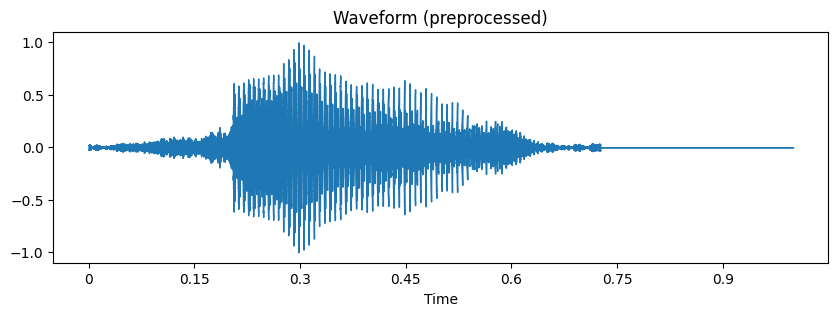

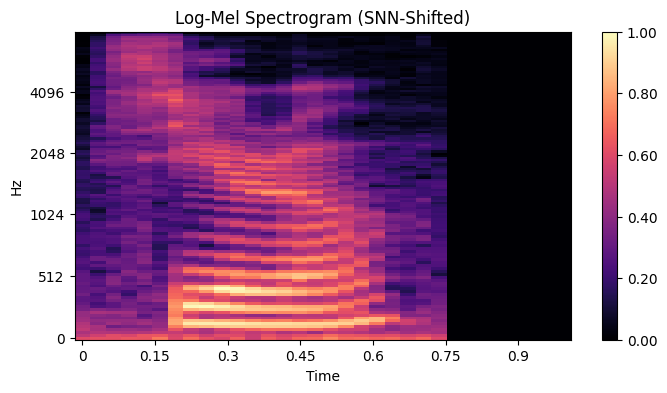

Plots saved to working dir for local export.


In [5]:
def test_preprocessing(df, fixed_sample=False, random_seed=RANDOM_SEED):
    """
    Test preprocessing on a sample file, print shapes, and plot/save visuals.
    
    Args:
        df (pd.DataFrame): Metadata DF.
        fixed_sample (bool): If True, use first good file; else random.
        random_seed (int): Seed for random choice.
    
    Example:
        test_preprocessing(df, fixed_sample=True)
    """
    # Filter to good files
    good_df = df[df['flag_bad_name'] == False]
    if good_df.empty:
        print("No good files to test.")
        return
    
    if fixed_sample:
        sample_path = good_df['path'].iloc[0]
    else:
        np.random.seed(random_seed)  # Use np for array choice
        sample_path = np.random.choice(good_df['path'].values)
    
    try:
        y, sr = load_and_preprocess(sample_path)
        logmel = to_logmel(y, sr, positive_shift=True)  # Enable for SNN positivity
        
        # Assert shapes
        expected_time_frames = (TARGET_LEN // HOP_LENGTH) + 1  # ~32
        assert y.shape == (TARGET_LEN,), f"Unexpected wave shape: {y.shape}"
        assert logmel.shape == (N_MELS, expected_time_frames), f"Unexpected log-Mel shape: {logmel.shape}"
        
        print(f"Sample path: {sample_path}")
        print(f"Wave shape: {y.shape}, log-Mel shape: {logmel.shape}")
        print(f"Log-Mel range (for SNN): min={logmel.min():.2f}, max={logmel.max():.2f}")  # Verify [0,1] shift
        
        # Plot waveform
        plt.figure(figsize=(10, 3))
        librosa.display.waveshow(y, sr=sr)
        plt.title("Waveform (preprocessed)")
        plt.savefig(WORK_DIR / "sample_waveform.png")
        plt.show()
        plt.close()
        
        # Plot spectrogram
        plt.figure(figsize=(8, 4))
        librosa.display.specshow(logmel, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
        plt.colorbar(format="%+2.0f dB" if not True else "%.2f")  # Adjust for shift
        plt.title("Log-Mel Spectrogram (SNN-Shifted)")
        plt.savefig(WORK_DIR / "sample_logmel.png")
        plt.show()
        plt.close()
        
        print("Plots saved to working dir for local export.")
    except Exception as e:
        print(f"Error testing {sample_path}: {e}")

# Run test (use fixed for reproducibility, or False for random)
test_preprocessing(df, fixed_sample=True)

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 5: Feature Extraction Loop (Preview)</b></font></p>

In [6]:
def extract_features(df, n_samples=None, cache_file=None, desc="Extracting features"):
    """
    Extract log-Mel features from a subset or full DF.
    
    Args:
        df (pd.DataFrame): Metadata DF.
        n_samples (int): Number to sample (None for all).
        cache_file (Path): Optional path to save/load .npy.
        desc (str): Progress description.
    
    Returns:
        features (np.ndarray): Stacked log-Mel arrays.
        valid_paths (list): Paths of successfully processed files.
    
    Example:
        sample_features, _ = extract_features(df, n_samples=100, cache_file=CACHE_DIR / "sample_features.npy")
    """
    # Filter good files
    good_df = df[df['flag_bad_name'] == False]
    if good_df.empty:
        raise ValueError("No good files to extract features from.")
    
    # Sample if specified
    if n_samples is not None:
        good_df = good_df.sample(min(n_samples, len(good_df)), random_state=RANDOM_SEED)
    
    paths = good_df['path'].tolist()
    
    # Optional: Load from cache
    if cache_file and cache_file.exists():
        print(f"Loading features from cache: {cache_file}")
        return np.load(cache_file), paths
    
    features = []
    valid_paths = []
    expected_shape = (N_MELS, (TARGET_LEN // HOP_LENGTH) + 1)  # (128, 32); or (3,128,32) if deltas
    
    for p in tqdm(paths, desc=desc):
        try:
            y, sr = load_and_preprocess(p)
            logmel = to_logmel(y, sr, positive_shift=True)  # Enable for SNN positivity
            # Optional: Stack deltas for temporal dynamics in SNN (uncomment and update model input channels=3)
            # logmel = np.stack([logmel, librosa.feature.delta(logmel), librosa.feature.delta(logmel, order=2)])
            assert logmel.shape == expected_shape, f"Shape mismatch for {p}: {logmel.shape} != {expected_shape}"
            features.append(logmel)
            valid_paths.append(p)
        except Exception as e:
            logging.warning(f"Failed extracting {p}: {e}")
            continue
    
    if not features:
        raise ValueError("No features extracted.")
    
    features = np.stack(features)
    print(f"Feature batch shape: {features.shape}")
    if features.size > 0:
        print(f"Sample feature range (for SNN): min={features.min():.2f}, max={features.max():.2f}")
    
    # Save to cache
    if cache_file:
        np.save(cache_file, features)
        print(f"Features saved to {cache_file}")
    
    return features, valid_paths

# Run on sample (for testing)
sample_features, sample_paths = extract_features(
    df, 
    n_samples=100, 
    cache_file=CACHE_DIR / "sample_features.npy",
    desc="Extracting sample features"
)

Extracting sample features: 100%|██████████| 100/100 [00:00<00:00, 110.99it/s]

Feature batch shape: (100, 128, 32)
Sample feature range (for SNN): min=0.00, max=1.00
Features saved to /kaggle/working/cache/sample_features.npy


### <p align="justify"><font size="6" color="#d62b5b">Step 3: Feature Extraction and Dataset Preparation</font></p>
<p align="justify">

- 

- 

- 

- 

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 6: Cache Extraction</b></font></p>

In [7]:
# Full feature extraction and caching (per-file to avoid memory issues for 30k samples)
FEATURES_SUBDIR = CACHE_DIR / "features"
FEATURES_SUBDIR.mkdir(parents=True, exist_ok=True)

# Updated metadata path (will include feature_path)
META_PATH = CACHE_DIR / "metadata_with_features.csv"

def extract_and_cache_features(df, features_dir=FEATURES_SUBDIR, overwrite=False):
    """
    Extract log-Mel features for all good files, save each as .npy in features_dir,
    and add 'feature_path' to DF.
    
    Args:
        df (pd.DataFrame): Metadata DF.
        features_dir (Path): Directory to save .npy files.
        overwrite (bool): If True, re-extract even if exists.
    
    Returns:
        df (pd.DataFrame): Updated with 'feature_path'.
    """
    # Filter good files
    good_df = df[df['flag_bad_name'] == False].copy()
    if good_df.empty:
        raise ValueError("No good files to process.")
    
    feature_paths = []
    for idx, row in tqdm(good_df.iterrows(), total=len(good_df), desc="Extracting and caching features"):
        audio_path = row['path']
        # Create unique filename based on original (e.g., 0_01_0.npy)
        fname = Path(audio_path).name.replace('.wav', '.npy')
        feature_path = features_dir / fname
        
        if not overwrite and feature_path.exists():
            feature_paths.append(str(feature_path))
            continue
        
        try:
            y, sr = load_and_preprocess(audio_path)
            logmel = to_logmel(y, sr, positive_shift=True)  # Enable for SNN positivity
            # Optional: Stack deltas for temporal dynamics in SNN (uncomment and set model channels=3)
            # logmel = np.stack([logmel, librosa.feature.delta(logmel), librosa.feature.delta(logmel, order=2)])
            np.save(feature_path, logmel)
            feature_paths.append(str(feature_path))
        except Exception as e:
            logging.warning(f"Failed to process {audio_path}: {e}")
            feature_paths.append(None)  # Mark as failed
    
    good_df['feature_path'] = feature_paths
    # Drop failed rows (optional; or keep with None)
    good_df = good_df[good_df['feature_path'].notnull()]
    
    print(f"Processed {len(good_df)} features. Saved to {features_dir}")
    if len(good_df) > 0:
        sample_logmel = np.load(good_df['feature_path'].iloc[0])
        print(f"Sample feature range (for SNN): min={sample_logmel.min():.2f}, max={sample_logmel.max():.2f}")
    return good_df

# Check if cached metadata with features exists
if META_PATH.exists():
    meta_df = pd.read_csv(META_PATH)
    print(f"Loaded cached metadata with features: {meta_df.shape}")
    # Quick verification
    if 'feature_path' in meta_df.columns and os.path.exists(meta_df['feature_path'].iloc[0]):
        print(f"First feature path exists: {meta_df['feature_path'].iloc[0]}")
    else:
        print("Cache invalid; re-processing...")
        meta_df = extract_and_cache_features(df)
        meta_df.to_csv(META_PATH, index=False)
        print("Updated metadata saved.")
else:
    print("No cache found; processing full features...")
    meta_df = extract_and_cache_features(df)
    meta_df.to_csv(META_PATH, index=False)
    print("Metadata with features saved.")

# For cross-platform: Ensure paths use / (but Path handles it)
meta_df['feature_path'] = meta_df['feature_path'].str.replace("\\", "/")

# Preview
print("Fixed paths (preview):")
print(meta_df['feature_path'].head(3).tolist())
print(f"First path exists: {os.path.exists(meta_df['feature_path'].iloc[0])}")

No cache found; processing full features...


Extracting and caching features: 100%|██████████| 30000/30000 [04:33<00:00, 109.67it/s]


Processed 30000 features. Saved to /kaggle/working/cache/features
Sample feature range (for SNN): min=0.00, max=1.00
Metadata with features saved.
Fixed paths (preview):
['/kaggle/working/cache/features/0_01_0.npy', '/kaggle/working/cache/features/0_01_1.npy', '/kaggle/working/cache/features/0_01_10.npy']
First path exists: True


#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 7: Split by speaker (speaker-disjoint)</b></font></p>

Speakers: train=42, val=9, test=9
Split DFs saved to cache.
Train: 21000 samples, 42 speakers
Val: 4500 samples, 9 speakers
Test: 4500 samples, 9 speakers


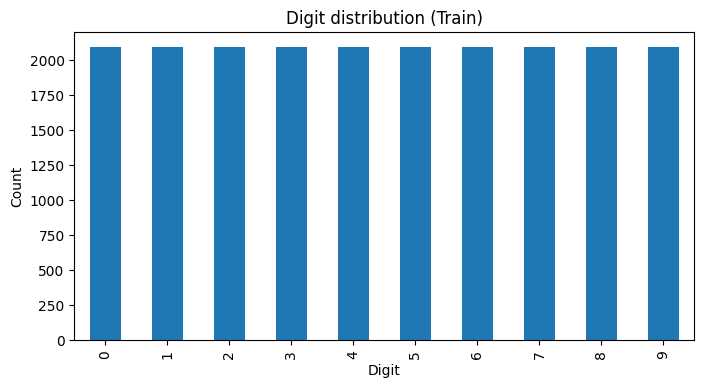

Train distribution plot saved.


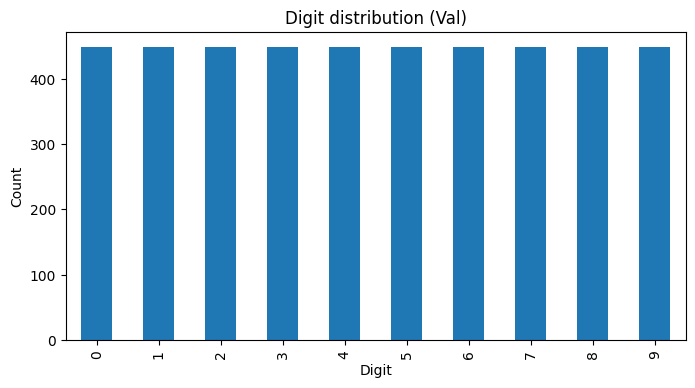

Val distribution plot saved.


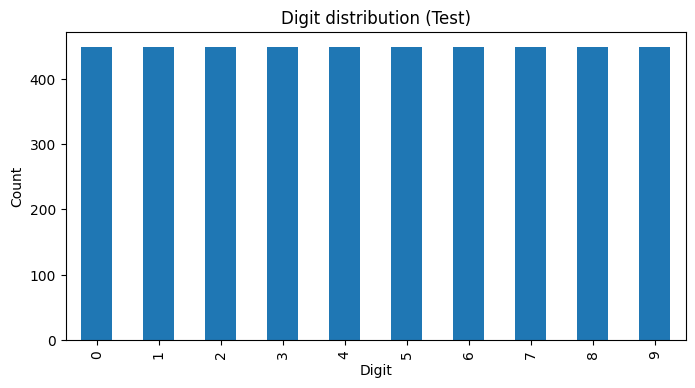

Test distribution plot saved.


In [8]:
# Dataset splitting by speakers (speaker-independent)
def split_dataset_by_speakers(df, test_size=0.3, val_size=0.5, random_seed=RANDOM_SEED):
    """
    Split metadata DF into train/val/test by speakers for independence.
    
    Args:
        df (pd.DataFrame): Metadata with 'speaker' column.
        test_size (float): Proportion for val+test.
        val_size (float): Split of temp into val/test.
        random_seed (int): For reproducibility.
    
    Returns:
        train_df, val_df, test_df (pd.DataFrame)
    """
    speakers = sorted(df['speaker'].unique())  # Sorted for consistency
    train_spk, temp_spk = train_test_split(speakers, test_size=test_size, random_state=random_seed)
    val_spk, test_spk = train_test_split(temp_spk, test_size=val_size, random_state=random_seed)
    
    print(f"Speakers: train={len(train_spk)}, val={len(val_spk)}, test={len(test_spk)}")
    
    def split_by_speakers(sub_df, spk_list):
        return sub_df[sub_df['speaker'].isin(spk_list)].reset_index(drop=True)
    
    train_df = split_by_speakers(df, train_spk)
    val_df = split_by_speakers(df, val_spk)
    test_df = split_by_speakers(df, test_spk)
    
    # Save splits for reproducibility
    train_df.to_csv(CACHE_DIR / "train_df.csv", index=False)
    val_df.to_csv(CACHE_DIR / "val_df.csv", index=False)
    test_df.to_csv(CACHE_DIR / "test_df.csv", index=False)
    print("Split DFs saved to cache.")
    
    return train_df, val_df, test_df

# Optional: Load from cache if exists (for repro; else process)
train_csv = CACHE_DIR / "train_df.csv"
if train_csv.exists():
    train_df = pd.read_csv(train_csv)
    val_df = pd.read_csv(CACHE_DIR / "val_df.csv")
    test_df = pd.read_csv(CACHE_DIR / "test_df.csv")
    print("Loaded split DFs from cache.")
else:
    train_df, val_df, test_df = split_dataset_by_speakers(meta_df)

# Print stats
for name, d in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    print(f"{name}: {len(d)} samples, {d['speaker'].nunique()} speakers")

# Plot and save digit distributions
for name, d in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    plt.figure(figsize=(8, 4))
    d['digit'].value_counts().sort_index().plot.bar()
    plt.title(f"Digit distribution ({name})")
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.savefig(WORK_DIR / f"digit_dist_{name.lower()}.png")
    plt.show()
    plt.close()
    print(f"{name} distribution plot saved.")

### <p align="justify"><font size="6" color="#d62b5b">Step 4: Model Selection and Training</font></p>
<p align="justify">

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 8: Digit Recognition (main task)</b></font></p>

- 10-class classification problem (digits 0–9) using 2D Mel spectrograms.

In [9]:
# Model definition (SNN version)
def init_weights(m):
    """Xavier (Glorot) uniform initialization for Conv2d and Linear layers."""
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class InputToSpiking(nn.Module):
    """Adds temporal noise (flickering) to input for rate coding."""
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, x):
        random_activation = torch.rand_like(x).to(self.device)
        return random_activation * x  # Flicker for spiking

class SpikingConvLayer(nn.Module):
    """Spiking conv layer with LIF dynamics."""
    def __init__(self, device, in_channels, out_channels, kernel_size=3, padding=1,
                 decay_multiplier=DECAY_MULTIPLIER, threshold=THRESHOLD, penalty_threshold=PENALTY_THRESHOLD):
        super().__init__()
        self.device = device
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        self.reset_state()
        self.apply(init_weights)

    def reset_state(self):
        self.prev_inner = None

    def forward(self, x):
        batch_size, _, h, w = x.shape
        if self.prev_inner is None:
            self.prev_inner = torch.zeros(batch_size, self.conv.out_channels, h, w).to(self.device)

        input_excitation = self.bn(self.conv(x))

        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier

        outer_excitation = F.relu(inner_excitation - self.threshold)

        do_penalize_gate = (outer_excitation > 0).float()
        inner_excitation = inner_excitation - do_penalize_gate * (
            self.penalty_threshold / self.threshold * inner_excitation)

        delayed_return_state = self.prev_inner
        self.prev_inner = inner_excitation
        return delayed_return_state

class OutputPooling(nn.Module):
    """Pools outputs over time (sum for rate)."""
    def __init__(self, average_output=False):
        super().__init__()
        self.reducer = lambda x, dim: x.sum(dim=dim) if not average_output else x.mean(dim=dim)

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)
        return self.reducer(x, 0)

class SNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, time_steps=TIME_STEPS, device=device):
        super().__init__()
        self.time_steps = time_steps
        self.device = device
        self.input_to_spiking = InputToSpiking(device)
        self.layer1 = SpikingConvLayer(device, 1, 32)  # Channels=1; 3 if deltas
        self.pool1 = nn.MaxPool2d(2)
        self.layer2 = SpikingConvLayer(device, 32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.3)
        
        # Hardcoded flattened (fixed shape after pools: 64 ch, H=128/4=32, W=32/4=8)
        flattened = 64 * 32 * 8  # 16384

        self.fc1 = nn.Linear(flattened, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.output_pooling = OutputPooling(average_output=False)
        
        self.to(self.device)  # Move to device

    def reset_state(self):
        self.layer1.reset_state()
        self.layer2.reset_state()

    def forward(self, x):
        self.reset_state()
        batch_size = x.size(0)
        outs = []

        for t in range(self.time_steps):
            xi = self.input_to_spiking(x)
            layer1_state = self.layer1(xi)
            cur = self.pool1(layer1_state)
            layer2_state = self.layer2(cur)
            cur = self.pool2(layer2_state)
            cur = self.dropout(cur)
            cur = cur.view(batch_size, -1)
            cur = F.relu(self.fc1(cur))
            cur = self.fc2(cur)
            outs.append(cur)

        out = self.output_pooling(outs)
        return out  # For CrossEntropyLoss

# Instantiate and move to device
model = SNN(num_classes=NUM_CLASSES).to(device)
print(model)

# Manual param count
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable params: {total_params:,}")

SNN(
  (input_to_spiking): InputToSpiking()
  (layer1): SpikingConvLayer(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): SpikingConvLayer(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (output_pooling): OutputPooling()
)
Total trainable params: 4,216,138


⚙️ Training Setup

In [10]:
# Helper: Load cached .npy features with progress and error handling
def load_features(df, desc="Loading features"):
    feats = []
    for path in tqdm(df['feature_path'], desc=desc):
        try:
            feat = np.load(path)  # (N_MELS, time_frames) e.g., (128, 32)
            assert feat.shape == (N_MELS, (TARGET_LEN // HOP_LENGTH) + 1), f"Shape mismatch: {feat.shape} for {path}"
            feats.append(feat)
        except Exception as e:
            logging.warning(f"Failed loading {path}: {e}")
            continue
    if not feats:
        raise ValueError("No features loaded.")
    return np.stack(feats)  # (samples, height, width)

# Load features
X_train = load_features(train_df, desc="Loading train features")
Y_train = train_df['digit'].to_numpy()
X_val = load_features(val_df, desc="Loading val features")
Y_val = val_df['digit'].to_numpy()
X_test = load_features(test_df, desc="Loading test features")  # Load test too for later eval
Y_test = test_df['digit'].to_numpy()

# Normalize: Compute mean/std from train (channel-wise for spectrograms)
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / (std + 1e-6)
X_val = (X_val - mean) / (std + 1e-6)
X_test = (X_test - mean) / (std + 1e-6)
print(f"Normalization: mean={mean:.4f}, std={std:.4f}")

# Print ranges for SNN verification (post-shift/norm should be ~[-3,3] or so)
print(f"Train range post-norm (for SNN): min={X_train.min():.2f}, max={X_train.max():.2f}")

# Convert to PyTorch tensors
def to_tensors(X, Y):
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (samples, 1, height, width); remove unsqueeze if deltas (channels=3)
    Y_tensor = torch.tensor(Y, dtype=torch.long)
    return X_tensor, Y_tensor

X_train_tensor, Y_train_tensor = to_tensors(X_train, Y_train)
X_val_tensor, Y_val_tensor = to_tensors(X_val, Y_val)
X_test_tensor, Y_test_tensor = to_tensors(X_test, Y_test)

# Save tensors for reproducibility/local use
torch.save({'X': X_train_tensor, 'Y': Y_train_tensor}, CACHE_DIR / "train_tensors.pt")
torch.save({'X': X_val_tensor, 'Y': Y_val_tensor}, CACHE_DIR / "val_tensors.pt")
torch.save({'X': X_test_tensor, 'Y': Y_test_tensor}, CACHE_DIR / "test_tensors.pt")
print("Tensors saved to cache.")

# DataLoaders with reproducible shuffling
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(RANDOM_SEED)

train_loader = DataLoader(
    TensorDataset(X_train_tensor, Y_train_tensor),
    batch_size=32,  # Reduced for SNN (time_steps may cause OOM with 64; tune based on GPU)
    shuffle=True,
    num_workers=2,  # Speed up; set 0 for CPU/repro issues
    worker_init_fn=seed_worker,
    generator=g
)
val_loader = DataLoader(
    TensorDataset(X_val_tensor, Y_val_tensor),
    batch_size=32,
    shuffle=False,
    num_workers=2
)
test_loader = DataLoader(  # For later eval
    TensorDataset(X_test_tensor, Y_test_tensor),
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Loading test features: 100%|██████████| 4500/4500 [00:00<00:00, 9757.87it/s]


Normalization: mean=0.2392, std=0.2440
Train range post-norm (for SNN): min=-0.98, max=3.12
Tensors saved to cache.


🏋️‍♂️ Training Loop

Training epochs:   5%|▌         | 1/20 [01:21<25:56, 81.91s/it]

Epoch [1/20] - Train Loss: 4.0426, Val Loss: 0.8839, Val Acc: 86.82%
Best model saved (Val Acc: 86.82%)


Training epochs:  10%|█         | 2/20 [02:42<24:18, 81.05s/it]

Epoch [2/20] - Train Loss: 0.2797, Val Loss: 0.6208, Val Acc: 93.82%
Best model saved (Val Acc: 93.82%)


Training epochs:  15%|█▌        | 3/20 [04:02<22:51, 80.67s/it]

Epoch [3/20] - Train Loss: 0.3099, Val Loss: 0.8799, Val Acc: 93.64%


Training epochs:  20%|██        | 4/20 [05:22<21:26, 80.43s/it]

Epoch [4/20] - Train Loss: 0.2114, Val Loss: 1.4004, Val Acc: 90.60%


Training epochs:  25%|██▌       | 5/20 [06:42<20:05, 80.36s/it]

Epoch [5/20] - Train Loss: 0.1897, Val Loss: 0.7164, Val Acc: 96.49%
Best model saved (Val Acc: 96.49%)


Training epochs:  30%|███       | 6/20 [08:02<18:43, 80.28s/it]

Epoch [6/20] - Train Loss: 0.1594, Val Loss: 2.0430, Val Acc: 92.04%


Training epochs:  35%|███▌      | 7/20 [09:23<17:22, 80.22s/it]

Epoch [7/20] - Train Loss: 0.0711, Val Loss: 0.6131, Val Acc: 96.78%
Best model saved (Val Acc: 96.78%)


Training epochs:  40%|████      | 8/20 [10:43<16:01, 80.15s/it]

Epoch [8/20] - Train Loss: 0.0206, Val Loss: 0.9392, Val Acc: 95.67%


Training epochs:  45%|████▌     | 9/20 [12:03<14:41, 80.15s/it]

Epoch [9/20] - Train Loss: 0.0264, Val Loss: 0.4474, Val Acc: 97.20%
Best model saved (Val Acc: 97.20%)


Training epochs:  50%|█████     | 10/20 [13:23<13:20, 80.10s/it]

Epoch [10/20] - Train Loss: 0.0258, Val Loss: 0.8952, Val Acc: 96.11%


Training epochs:  55%|█████▌    | 11/20 [14:43<12:00, 80.10s/it]

Epoch [11/20] - Train Loss: 0.0570, Val Loss: 1.4374, Val Acc: 95.20%


Training epochs:  60%|██████    | 12/20 [16:03<10:41, 80.16s/it]

Epoch [12/20] - Train Loss: 0.0394, Val Loss: 1.1411, Val Acc: 95.24%


Training epochs:  65%|██████▌   | 13/20 [17:23<09:21, 80.19s/it]

Epoch [13/20] - Train Loss: 0.0581, Val Loss: 0.6634, Val Acc: 98.16%
Best model saved (Val Acc: 98.16%)


Training epochs:  70%|███████   | 14/20 [18:43<08:00, 80.16s/it]

Epoch [14/20] - Train Loss: 0.0084, Val Loss: 0.6066, Val Acc: 97.78%


Training epochs:  75%|███████▌  | 15/20 [20:04<06:40, 80.17s/it]

Epoch [15/20] - Train Loss: 0.0016, Val Loss: 0.5227, Val Acc: 97.80%


Training epochs:  80%|████████  | 16/20 [21:24<05:20, 80.17s/it]

Epoch [16/20] - Train Loss: 0.0016, Val Loss: 0.5648, Val Acc: 97.49%


Training epochs:  85%|████████▌ | 17/20 [22:44<04:00, 80.16s/it]

Epoch [17/20] - Train Loss: 0.0068, Val Loss: 0.8418, Val Acc: 97.09%


Training epochs:  90%|█████████ | 18/20 [24:04<02:40, 80.18s/it]

Epoch [18/20] - Train Loss: 0.0016, Val Loss: 0.6065, Val Acc: 98.04%


Training epochs:  95%|█████████▌| 19/20 [25:25<01:20, 80.22s/it]

Epoch [19/20] - Train Loss: 0.0009, Val Loss: 0.6332, Val Acc: 97.64%


Training epochs:  95%|█████████▌| 19/20 [26:45<01:24, 84.49s/it]

Epoch [20/20] - Train Loss: 0.0000, Val Loss: 0.6347, Val Acc: 97.78%
Early stopping at epoch 20
✅ Training complete. Log saved to /kaggle/working/cache/training_log.csv


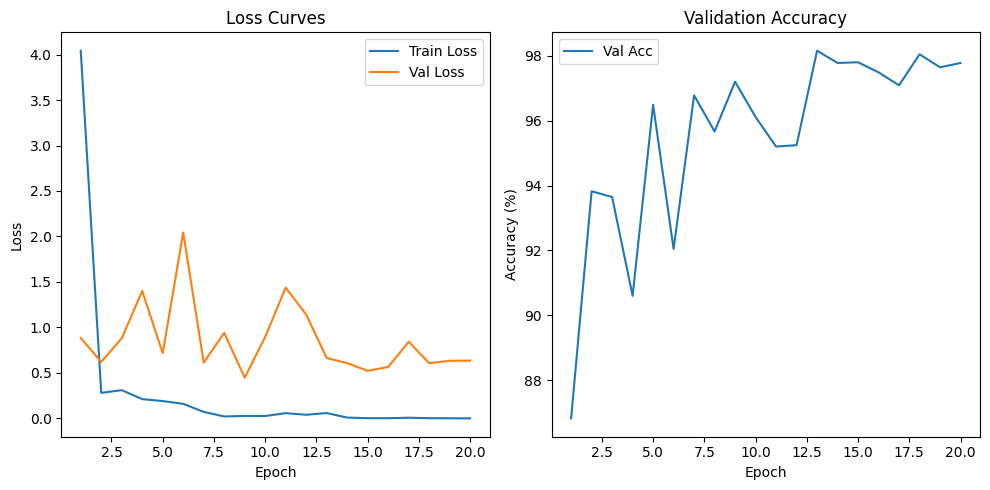

Metrics plot saved to working dir.


In [11]:
# Training loop with improvements
MODEL_PATH = WORK_DIR / "best_model.pth"
LOG_PATH = CACHE_DIR / "training_log.csv"

# Early stopping params (increased patience for SNN convergence)
patience = 7
best_val_acc = 0.0
epochs_no_improve = 0
early_stop = False

# Setup logging CSV
with open(LOG_PATH, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val Acc"])

train_losses, val_losses, val_accuracies = [], [], []

for epoch in tqdm(range(NUM_EPOCHS), desc="Training epochs"):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)  # SNN forward includes time loop/reset
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Stability
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    
    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    val_loss_val = val_loss / len(val_loader.dataset)
    val_acc = 100 * correct / total
    
    # Scheduler step
    scheduler.step(val_loss_val)
    
    # Logging
    train_losses.append(train_loss)
    val_losses.append(val_loss_val)
    val_accuracies.append(val_acc)
    with open(LOG_PATH, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, f"{train_loss:.4f}", f"{val_loss_val:.4f}", f"{val_acc:.2f}"])
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss_val:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Checkpoint best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"Best model saved (Val Acc: {val_acc:.2f}%)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            early_stop = True
            break

print("✅ Training complete. Log saved to", LOG_PATH)

# Plot metrics and save
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')
plt.tight_layout()
plt.savefig(WORK_DIR / "training_metrics.png")
plt.show()
plt.close()
print("Metrics plot saved to working dir.")

🧪 Evaluation & Test

✅ Test Loss: 0.3541, Test Accuracy: 98.67%


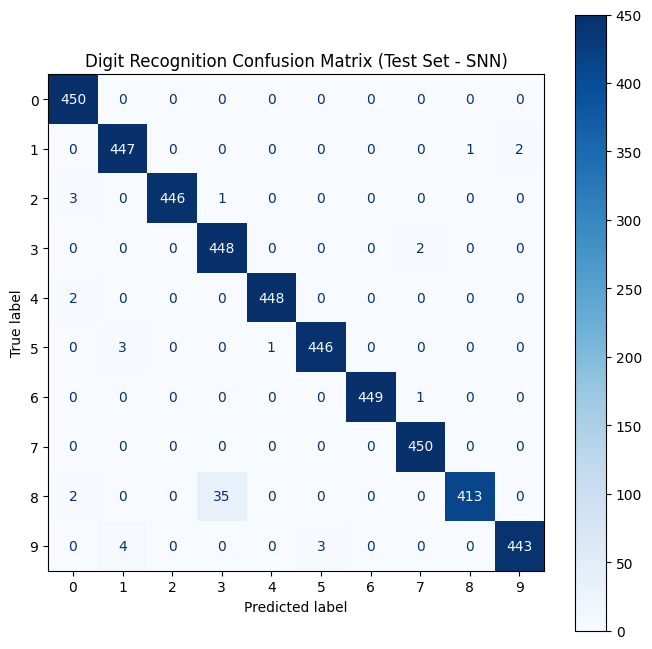

CM plot saved to working dir.

Classification Report:
              precision    recall  f1-score   support

           0     0.9847    1.0000    0.9923       450
           1     0.9846    0.9933    0.9889       450
           2     1.0000    0.9911    0.9955       450
           3     0.9256    0.9956    0.9593       450
           4     0.9978    0.9956    0.9967       450
           5     0.9933    0.9911    0.9922       450
           6     1.0000    0.9978    0.9989       450
           7     0.9934    1.0000    0.9967       450
           8     0.9976    0.9178    0.9560       450
           9     0.9955    0.9844    0.9899       450

    accuracy                         0.9867      4500
   macro avg     0.9872    0.9867    0.9866      4500
weighted avg     0.9872    0.9867    0.9866      4500

Report saved to working dir.


In [12]:
# Evaluation on test set
# Load best model (ensure using the trained/best weights)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
model.eval()

# Accumulate predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)  # SNN forward with time steps
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

test_loss /= len(test_loader.dataset)
acc = 100 * correct / total
print(f"✅ Test Loss: {test_loss:.4f}, Test Accuracy: {acc:.2f}%")

# Log to CSV
with open(LOG_PATH, 'a', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Test", f"{test_loss:.4f}", "-", f"{acc:.2f}"])

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Digit Recognition Confusion Matrix (Test Set - SNN)")
plt.savefig(WORK_DIR / "confusion_matrix.png")
plt.show()
plt.close()
print("CM plot saved to working dir.")

# Classification Report
report = classification_report(all_labels, all_preds, digits=4)
print("\nClassification Report:")
print(report)
with open(WORK_DIR / "classification_report.txt", 'w') as f:
    f.write(report)
print("Report saved to working dir.")